In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from autoencoder import AutoEncoder, VariationalAutoEncoder, RMS
import resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import PurePosixPath as Path
from tensorflow.keras.models import Model

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load in RMS data for tests

In [2]:
exps = ['Test 5', 'Test 7', 'Test 8', 'Test 9']
# exps = ['Test 5', 'Test 9']
rms = {}

for test in exps:
    rms[test] = resources.ae.RMS(test)
    rms[test].data.drop(['0', '1', '2',], axis=1, inplace=True)
    
try:
    rms['Test 5'].data.drop(['23', '24'], axis=1, inplace=True)
except KeyError:
    pass

--------------------------------------------------
Loaded RMS data for "22_08_03_grit1000"
Experiemnt No: Test 5
Number of files: 213
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_07_weartest_1000"
Experiemnt No: Test 7
Number of files: 163
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_09_weartest_1000"
Experiemnt No: Test 8
Number of files: 176
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_30_weartest_1000"
Experiemnt No: Test 9
Number of files: 158
--------------------------------------------------


# Setup Variational Autoencoder for each Test
- The model is trained over a small section of the test depending on `train_slice`.
- The model parameters are specified within the `params` dict.

In [3]:
autoe = {}
for test in exps:
        """
        autoe[test] = VariationalAutoEncoder(rms[test],
                                           tb=False,
                                           tb_logdir=rms[test].exp_name,
                                           train_slice=(0, 50),
                                           random_state=1,
                                           params={'latent_dim': 2,
                                                   'n_size': [32, 16],
                                                   'epochs': 300,
                                                   'batch_size': 20,
                                                   'callbacks': [
                                                           tf.keras.callbacks.EarlyStopping(
                                                                monitor='val_loss',
                                                                patience=30,
                                                                mode='min',
                                                                start_from_epoch=100,
                                                           ),
                                                        ]
                                                   }
                                           )
        """
        autoe[test] = AutoEncoder(rms[test],
                                  tb=False,
                                  tb_logdir=rms[test].exp_name.upper().replace(' ', '_'),
                                  train_slice=(0, 75),
                                  val_frac=0.33,
                                  random_state=2,
                                  params={'n_bottleneck': 3,
                                          'n_size': [64, 64],
                                          'epochs': 750,
                                          'batch_size': 40,
                                          'loss': 'mse',
                                          'callbacks': [
                                                  tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=80,
                                                              mode='min',
                                                              start_from_epoch= 150,
                                                  ),
                                                #   tf.keras.callbacks.ReduceLROnPlateau(
                                                #                 monitor='val_loss',
                                                #                 mode='min',
                                                #                 patience=25,
                                                #                 factor=0.01,
                                                #   ),
                                                ]

                                          }
                                  )       

Pre-Processing Data:
	Training Data: slice(0, 75, None)
	Input train shape: (50, 407)
	Input val shape: (25, 407)

AUTOE-Test_5-E-750-L-[64, 64, 3, 64, 64]-20230531-111211

Pre-Processing Data:
	Training Data: slice(0, 75, None)
	Input train shape: (50, 410)
	Input val shape: (25, 410)

AUTOE-Test_7-E-750-L-[64, 64, 3, 64, 64]-20230531-111211

Pre-Processing Data:
	Training Data: slice(0, 75, None)
	Input train shape: (50, 393)
	Input val shape: (25, 393)

AUTOE-Test_8-E-750-L-[64, 64, 3, 64, 64]-20230531-111211

Pre-Processing Data:
	Training Data: slice(0, 75, None)
	Input train shape: (50, 394)
	Input val shape: (25, 394)

AUTOE-Test_9-E-750-L-[64, 64, 3, 64, 64]-20230531-111211



In [4]:
platform = os.name
if platform == 'nt':
    onedrive = Path(r'C:\Users\tomje\OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
elif platform == 'posix':
    onedrive = Path(r'/mnt/c/Users/tomje/OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
print(TB_DIR)

/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard


In [5]:
# add model checkpoint callback after creating model
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    if not os.path.exists(model_folder):
       os.makedirs(model_folder)
    assert os.path.exists(model_folder)

    autoe[test].model.callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
        filepath=model_folder.joinpath(f'{name}.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
        )
    )

# Train each autoe on the training data
- `x` is the inputted data for training, which is `autoe.train_data`
- `val_data` is the validation data from `autoe.val_data`

In [6]:
for test in exps:
        autoe[test].fit(x=autoe[test].train_data,
                      val_data=autoe[test].val_data,
                      verbose=0,
                      use_multiprocessing=True,
                      )

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

## Reload saved weights from best model

In [7]:
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    autoe[test].model.model_.load_weights(
        TB_DIR.joinpath(model_folder.joinpath(f'{name}.h5'),),
    )
    autoe[test].pred = None
    autoe[test].scores = None

# Results Visualisation

## Loss plot of each trained model

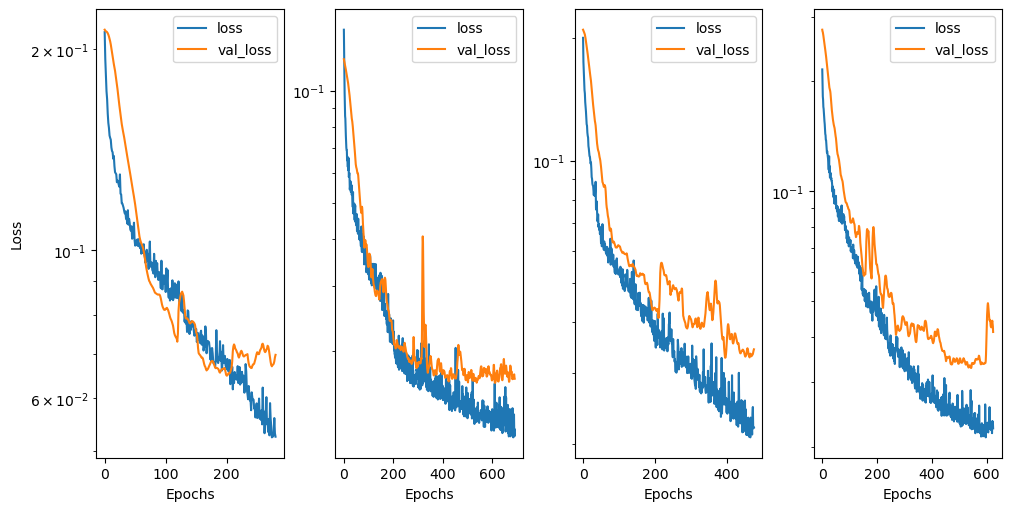

In [8]:
fig, ax = plt.subplots(1, len(exps),
                       figsize=(10,5),
                       constrained_layout=True,
                       )
# ax = ax.ravel()
for i, test in enumerate(exps):
    axis = fig.axes[i]
    autoe[test].loss_plot(plt_ax=axis)
    axis.set_yscale('log')
    if i > 0:
        axis.set_ylabel('')

## Score each model
- Models scored on train, validation and whole dataset

In [9]:
for test in exps:
    print(f'\n {test}')
    pred_tr, scores_tr = autoe[test].score('train')
    pred_val, scores_val = autoe[test].score('val')
    pred_data, scores_data = autoe[test].score('dataset')


 Test 5

Train Scores:
	MAE: 0.20076
	MSE: 0.06879
	R2: -0.25490

Val Scores:
	MAE: 0.19782
	MSE: 0.06489
	R2: -0.12831

Dataset Scores:
	MAE: 0.45743
	MSE: 0.47161
	R2: -0.98604

 Test 7

Train Scores:
	MAE: 0.08539
	MSE: 0.01248
	R2: 0.46718

Val Scores:
	MAE: 0.09816
	MSE: 0.01645
	R2: 0.35171

Dataset Scores:
	MAE: 0.12797
	MSE: 0.03289
	R2: 0.20421

 Test 8

Train Scores:
	MAE: 0.11850
	MSE: 0.02377
	R2: 0.40613

Val Scores:
	MAE: 0.13766
	MSE: 0.03264
	R2: 0.26855

Dataset Scores:
	MAE: 0.21017
	MSE: 0.19202
	R2: 0.17323

 Test 9

Train Scores:
	MAE: 0.11864
	MSE: 0.02265
	R2: 0.38381

Val Scores:
	MAE: 0.14152
	MSE: 0.03283
	R2: 0.12548

Dataset Scores:
	MAE: 0.28822
	MSE: 0.21081
	R2: -0.21175


## Show histogram of scores across whole dataset

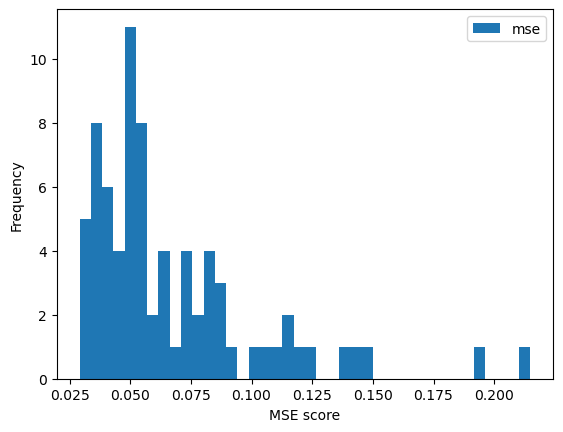

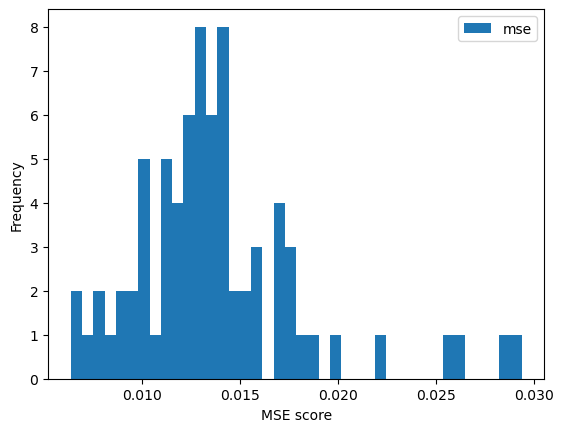

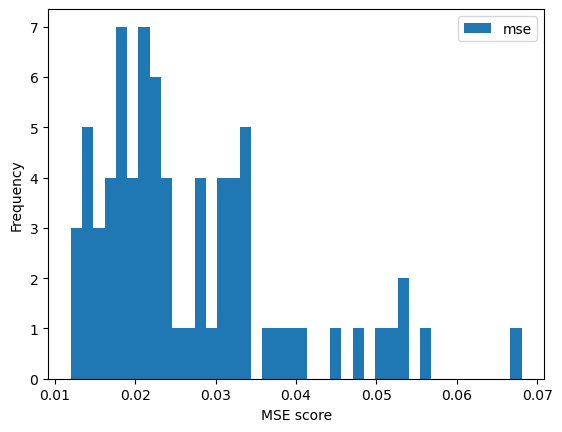

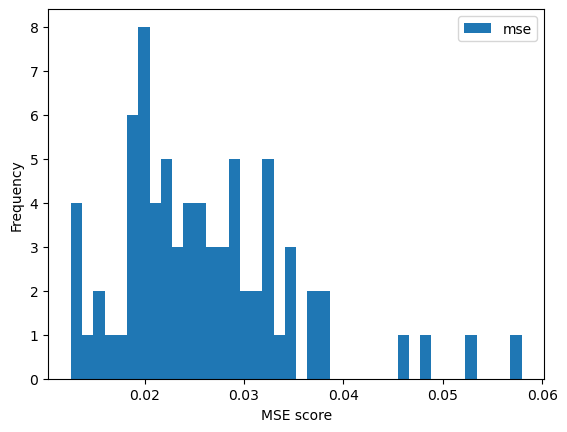

In [10]:
for test in exps:
    fig, ax = autoe[test].hist_scores(['mse'])

## Show model recreation capability of training and validation sets

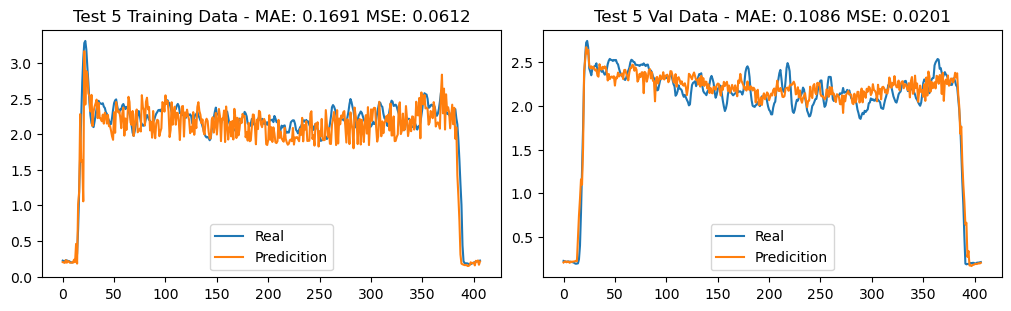

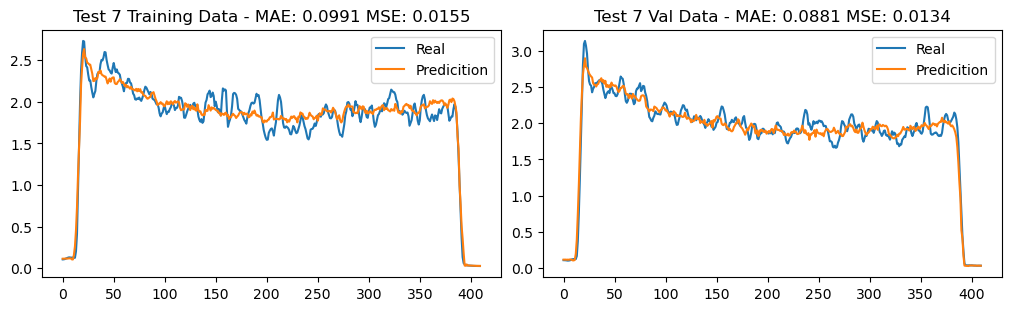

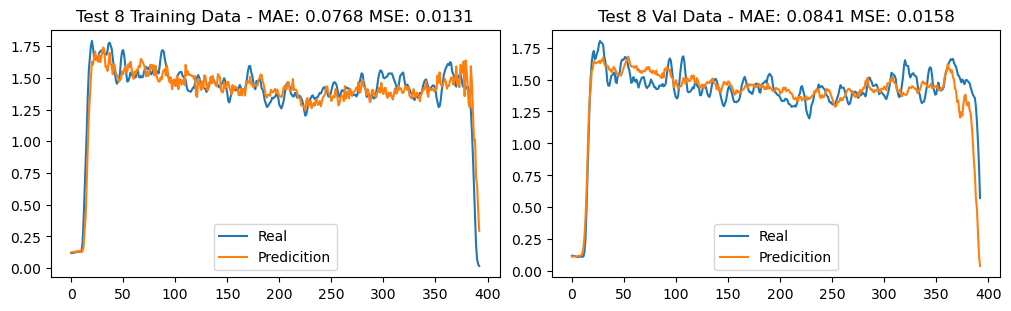

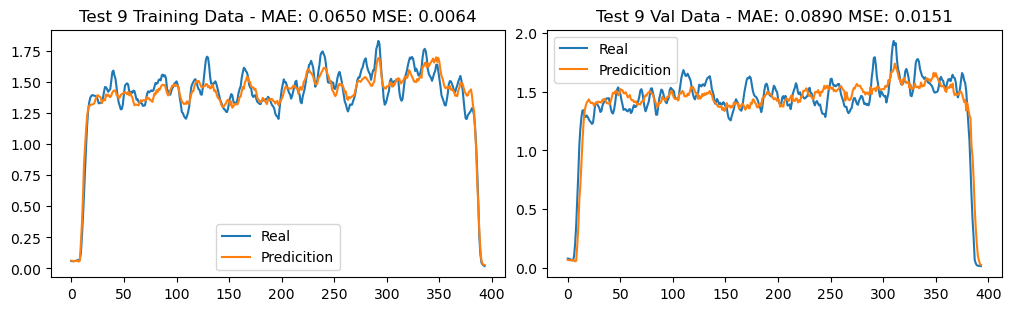

In [11]:
for test in exps:
    fig, ax = plt.subplots(1, 2, figsize=(10,3), constrained_layout=True)
    ax = ax.ravel()

    # Training plot
    ax[0] = autoe[test].pred_plot(autoe[test]._ind_tr[0], plt_ax=ax[0])
    ax[0].set_title(f'{autoe[test].RMS.exp_name} Training Data - {ax[0].get_title()}')

    # Validation plot
    ax[1] = autoe[test].pred_plot(autoe[test]._ind_val[0], plt_ax=ax[1])
    ax[1].set_title(f'{autoe[test].RMS.exp_name} Val Data - {ax[1].get_title()}')

## Thresholds for anomaly detection of each model

In [12]:
for test in exps:
    autoe[test].thres


Cutoffs:
	MAE cutoff: 0.25091
	MSE cutoff: 0.10359
	R2 cutoff: -0.79858

Cutoffs:
	MAE cutoff: 0.10299
	MSE cutoff: 0.01826
	R2 cutoff: 0.26021

Cutoffs:
	MAE cutoff: 0.15074
	MSE cutoff: 0.03837
	R2 cutoff: 0.14269

Cutoffs:
	MAE cutoff: 0.14684
	MSE cutoff: 0.03485
	R2 cutoff: 0.06234


## Show scores against threshold

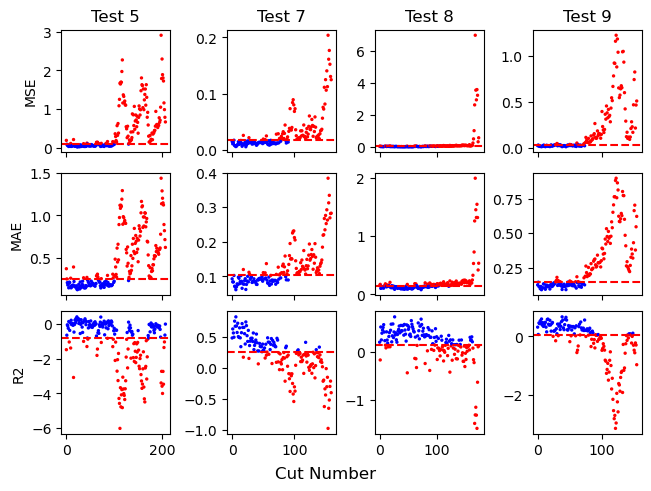

In [13]:
metrics = ['mse', 'mae', 'r2']

fig, ax = plt.subplots(len(metrics), len(exps),
                    #    figsize=(15, 5),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )
axes = fig.axes

for i, test in enumerate(exps):
    for j, met in enumerate(metrics):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        axes[(i)].set_title(test)
        axes[(len(exps) * j) + i].set_ylabel('')
        axes[(len(exps) * j) + i].set_xlabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')

_ = fig.supxlabel('Cut Number')

In [14]:
dfs = [pd.DataFrame(autoe[test].scores) for test in exps]
df = pd.concat(dfs, keys=exps, names=['Test', 'Metrics'])
for test in exps:
    print(f'\n {test}')
    print(df.loc[test].describe())


 Test 5
              mae         mse          r2
count  208.000000  208.000000  208.000000
mean     0.457434    0.471608   -0.986040
std      0.325620    0.568363    1.393070
min      0.128503    0.029116   -6.017826
25%      0.189326    0.057313   -1.599788
50%      0.295888    0.162089   -0.351179
75%      0.662479    0.734638   -0.010436
max      1.437899    2.905374    0.423004

 Test 7
              mae         mse          r2
count  160.000000  160.000000  160.000000
mean     0.127972    0.032894    0.204210
std      0.058993    0.034819    0.309385
min      0.061823    0.006335   -0.971112
25%      0.088920    0.013318    0.053003
50%      0.108858    0.020352    0.240410
75%      0.145810    0.035536    0.413343
max      0.383977    0.203903    0.823441

 Test 8
              mae         mse          r2
count  173.000000  173.000000  173.000000
mean     0.210172    0.192025    0.173233
std      0.257000    0.748544    0.364967
min      0.081287    0.011985   -1.599652
25%    

## autoe models latent space

In [15]:
# for test in exps:
#     fig, ax = autoe[test].plot_latent_space()

## Wear measurements comparison

/tmp/ipykernel_4516/1395292657.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


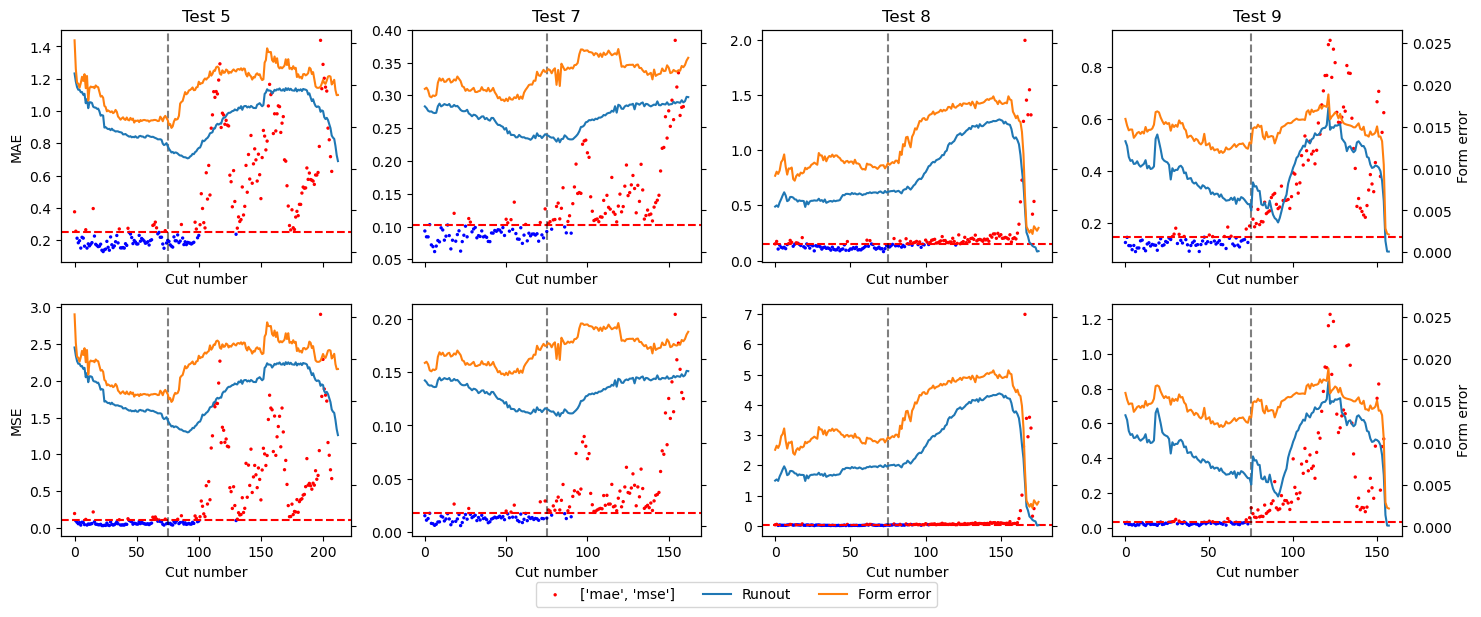

In [16]:
features = ['Runout', 'Form error']
metric = ['mae', 'mse']


fig, ax = plt.subplots(len(metric), len(exps),
                       figsize=(15, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )

ax2 = []
for a in ax.ravel():
    ax2.append(a.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(exps):
    axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        # vert line to show where training data ends
        axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop,
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        for feature in features:
            feat = exp.features[feature]
            axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)

        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel(f'{feature}')


for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              [metric] + lab2, 
              loc='center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()

## Just Encoder

In [17]:
encoders = {}
for test in exps:
    ae = autoe[test].model.model_
    encoders[test] = Model(inputs=ae.get_layer('Encoder').input, outputs=ae.get_layer('Encoder').output)

In [18]:
encoded_inputs = {}
for test in exps:
    inp = rms[test].data.values
    inp = autoe[test].scaler.transform(inp.T)
    encoded_inputs[test] = encoders[test].predict(inp, verbose=0)

In [19]:
ARGET = 'Runout'

encoded_main_dfs = {}
for test in exps:
    exp = resources.load(test)
    target = exp.features[TARGET]
    if exp.test_info.testno == 5:
        target = target.drop([23, 24], axis=0)
    target = target.drop([0, 1, 2], axis=0).values
    inputs = np.concatenate([encoded_inputs[test], target.reshape(-1, 1)], axis=1)
    encoded_main_dfs[test] = pd.DataFrame(inputs, columns=['L1', 'L2', 'L3', 'Target'])

NameError: name 'TARGET' is not defined

In [ ]:
for key, data in encoded_main_dfs.items():
    print(f'\n{key}')
    print(data.describe())
    


Test 5
               L1          L2          L3          L4          L5      Target
count  208.000000  208.000000  208.000000  208.000000  208.000000  208.000000
mean     0.948163    2.702909    0.535195    0.975881    0.491725    0.015733
std      2.276788    3.305703    1.730085    1.699894    1.291235    0.002598
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.010886
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.013706
50%      0.000000    1.642910    0.000000    0.042565    0.000000    0.015876
75%      0.511396    4.311814    0.000000    1.285036    0.069358    0.017779
max     12.880632   15.038169   11.819109   11.740461    8.493661    0.019579

Test 7
               L1          L2          L3          L4          L5      Target
count  160.000000  160.000000  160.000000  160.000000  160.000000  160.000000
mean     0.928354    0.394994    0.537045    0.654042    1.098700    0.015996
std      0.827135    1.020287    1.337724    1.2

In [299]:
main_df = encoded_main_dfs[list(encoded_main_dfs.keys())[0]]
ml = resources.LSTM_Model(feature_df=main_df,
                          target='Target',
                          tb=True,
                          tb_logdir='autoe_encoder_test',
                          params={'seq_len': 20,
                                  'epochs': 2000,
                                  'no_nodes': 64,
                                  'batch_size': 30,
                                  'no_layers': 3,
                                  'no_dense': 1,
                                  'dropout': 0.1,
                                  'loss': 'mse',
                                  'callbacks': [tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=100,
                                                              mode='min',
                                                              start_from_epoch= 100,
                                                  ),]
                                  },
                        #   random_state=10,
                          shuffle=True,
)

Overlapping sections between exps not removed!


In [300]:
ml.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath=ml._run_name + f'{ml._run_name.split(ml.tb_log_dir)[-1]}.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
)

In [301]:
ml.fit(validation_split=0.33, verbose=0)

-----------------------------------------------------------------
LSTM-WLEN-20-E-2000-B-30-L-[64 64 64 64]-D-0.1-20230531-104004


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

In [302]:
ml.model.model_.load_weights(
    ml._run_name + f'{ml._run_name.split(ml.tb_log_dir)[-1]}.h5',
)
# ml.model.model_.load_weights('/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard/LSTM/autoe_encoder_test/LSTM-WLEN-15-E-1000-B-50-L-[64 64 64 64]-D-0.1-20230530-105521/LSTM-WLEN-15-E-1000-B-50-L-[64 64 64 64]-D-0.1-20230530-105521.h5')

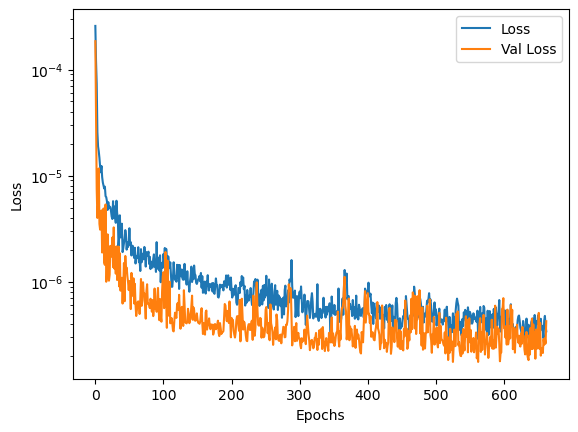

In [303]:
fig, ax = ml.loss_plot()
ax.set_yscale('log')

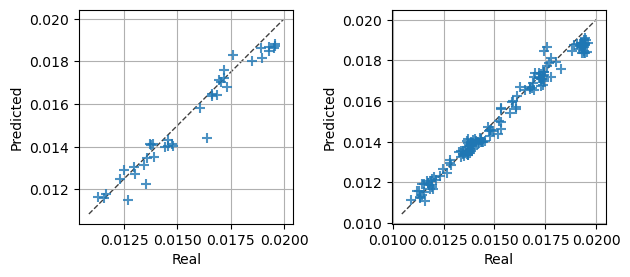

In [304]:
def pred_real_plot(y, y_pred, ax):
    ax.scatter(y, y_pred, marker='+', alpha=0.8, s=50)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

    ax.set_axisbelow(True)
    ax.grid()
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=1)
    ax.set_aspect('equal')
    ax.set_xlabel('Real')
    ax.set_ylabel('Predicted')
    return ax

fig, ax = plt.subplots(1, 2)
ax[0] = pred_real_plot(ml.val_data[1], ml.model.predict(ml.val_data[0], verbose=0), ax[0])
ax[1] = pred_real_plot(ml.train_data[1], ml.model.predict(ml.train_data[0], verbose=0), ax[1])
fig.tight_layout()

In [305]:
print('TRAINING DATA')
_ = ml.score(X=ml.train_data[0],
              y=ml.train_data[1],
              plot_fig=False,
              )
print('\nVALIDATION DATA')
_ = ml.score(plot_fig=False)

TRAINING DATA
-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 0.314 um
MSE = 0.160 um^2
R^2 = 0.977

VALIDATION DATA
-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 0.480 um
MSE = 0.378 um^2
R^2 = 0.941


/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


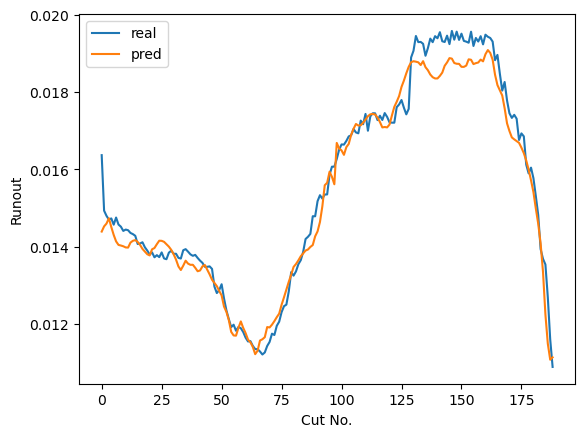

In [306]:
all_x= main_df.iloc[:, :-1]
all_y= main_df.iloc[:, -1] 

all_x= ml.scaler.transform(all_x)
all_data = np.column_stack([all_x, all_y])

all_data = ml.sequence_data(all_data)
all_data = pd.DataFrame(all_data , columns=['features', 'target'])

all_x= []
all_y= []
for X, y in all_data .values:
    all_x.append(X)
    all_y.append(y)
all_x= np.array(all_x)
all_y= np.array(all_y)
all_data = [all_x, all_y]

all_pred = ml.model.predict(all_data[0], verbose=0)
fig, ax = plt.subplots()
ax.plot(all_data[1], label='real')
ax.plot(all_pred, label='pred')
ax.legend()
ax.set_xlabel('Cut No.')
ax.set_ylabel(TARGET);

In [307]:
tr_split = 50

main_df = encoded_main_dfs[list(encoded_main_dfs.keys())[1]]
ml_2 = resources.LSTM_Model(feature_df=main_df.iloc[:tr_split],
                          target='Target',
                          tb=True,
                          tb_logdir='autoe_encoder_test',
                          params={'seq_len': 15,
                                  'epochs': 1000,
                                  'no_nodes': 16,
                                  'batch_size': 30,
                                  'no_layers': 2,
                                  'no_dense': 1,
                                  'dropout': 0.1,
                                  'loss': 'mse',
                                  'callbacks': [tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=150,
                                                              mode='min',
                                                              start_from_epoch= 100,
                                                  ),]
                                  },
                          # random_state=1,
                        #   shuffle=False,
)

Overlapping sections between exps not removed!


In [308]:
ml_2.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath=ml_2._run_name + f'{ml_2._run_name.split(ml_2.tb_log_dir)[-1]}.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
)

In [309]:
ml_2.model.initialize(X=ml_2.train_data[0], y=ml_2.train_data[1]);

In [310]:
ml_2.model.model_.load_weights(
    ml._run_name + f'{ml._run_name.split(ml.tb_log_dir)[-1]}.h5',
)

ValueError: Layer count mismatch when loading weights from file. Model expected 4 layers, found 5 saved layers.

In [ ]:
ml_2.fit(validation_split=0.33, verbose=0)

-----------------------------------------------------------------
LSTM-WLEN-15-E-1000-B-30-L-[16 16 16]-D-0.1-20230531-094552


Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

In [ ]:
ml_2.model.model_.load_weights(
    ml_2._run_name + f'{ml_2._run_name.split(ml_2.tb_log_dir)[-1]}.h5',
)

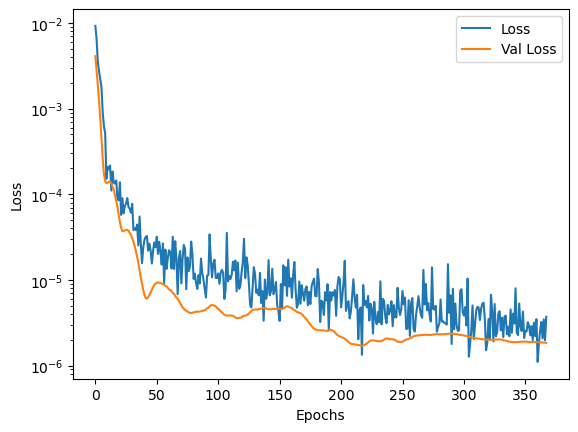

In [ ]:
fig, ax = ml_2.loss_plot()
ax.set_yscale('log')

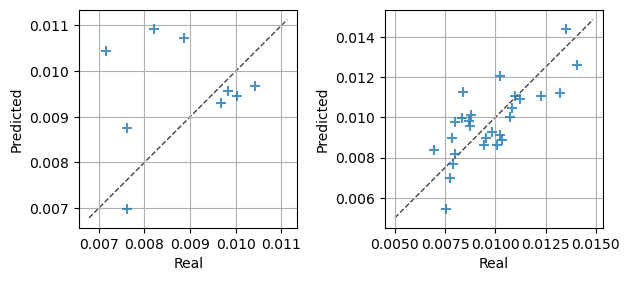

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0] = pred_real_plot(ml_2.val_data[1], ml_2.model.predict(ml_2.val_data[0], verbose=0), ax[0])
ax[1] = pred_real_plot(ml_2.train_data[1], ml_2.model.predict(ml_2.train_data[0], verbose=0), ax[1])
fig.tight_layout()

In [ ]:
print('TRAINING DATA')
_ = ml_2.score(X=ml_2.train_data[0],
              y=ml_2.train_data[1],
              plot_fig=False,
              )
print('\nVALIDATION DATA')
_ = ml_2.score(plot_fig=False)

TRAINING DATA
-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 1.114 um
MSE = 1.668 um^2
R^2 = 0.525

VALIDATION DATA
-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 1.294 um
MSE = 2.717 um^2
R^2 = -1.057


In [ ]:
rest_X = main_df.iloc[tr_split-15:, :-1]
rest_Y = main_df.iloc[tr_split-15:, -1] 

rest_X = ml_2.scaler.transform(rest_X)
rest_data = np.column_stack([rest_X, rest_Y])

rest_data = ml_2.sequence_data(rest_data)
rest_data = pd.DataFrame(rest_data, columns=['features', 'target'])

rest_X = []
rest_Y = []
for X, y in rest_data.values:
    rest_X.append(X)
    rest_Y.append(y)
rest_X = np.array(rest_X)
rest_Y = np.array(rest_Y)
rest_data = [rest_X, rest_Y]

/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 26.366 um
MSE = 1268.125 um^2
R^2 = -84.015


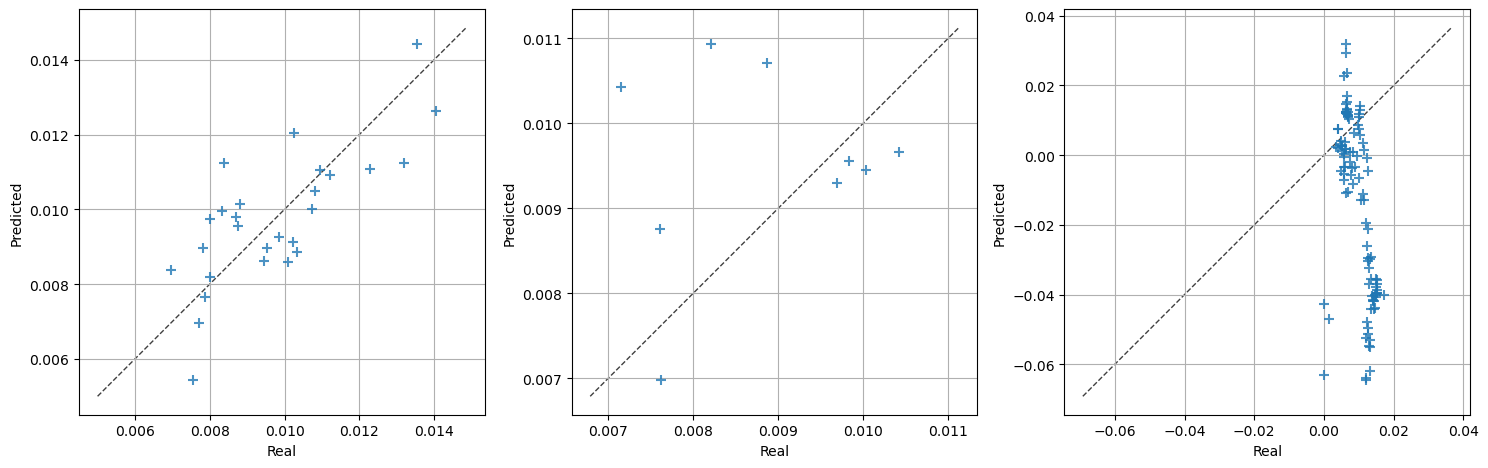

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0] = pred_real_plot(ml_2.train_data[1], ml_2.model.predict(ml_2.train_data[0], verbose=0), ax[0])
ax[1] = pred_real_plot(ml_2.val_data[1], ml_2.model.predict(ml_2.val_data[0], verbose=0), ax[1])
ax[2] = pred_real_plot(rest_data[1], ml_2.model.predict(rest_data[0], verbose=0), ax[2])
fig.tight_layout()
ml_2.score(X=rest_data[0], y=rest_data[1], plot_fig=False);


/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


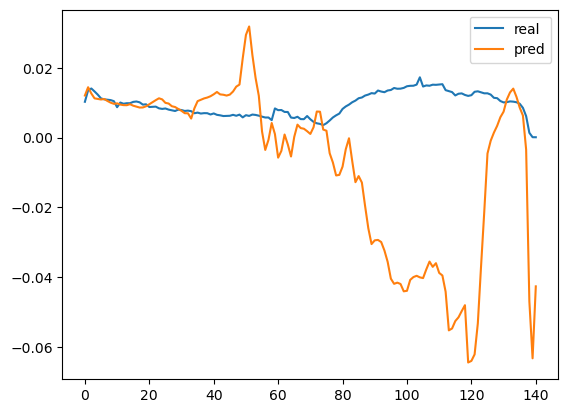

In [ ]:
all_x= main_df.iloc[:, :-1]
all_y= main_df.iloc[:, -1] 

all_x= ml_2.scaler.transform(all_x)
all_data = np.column_stack([all_x, all_y])

all_data = ml_2.sequence_data(all_data)
all_data = pd.DataFrame(all_data , columns=['features', 'target'])

all_x= []
all_y= []
for X, y in all_data .values:
    all_x.append(X)
    all_y.append(y)
all_x= np.array(all_x)
all_y= np.array(all_y)
all_data = [all_x, all_y]

all_pred = ml_2.model.predict(all_data[0], verbose=0)
fig, ax = plt.subplots()
ax.plot(all_data[1], label='real')
ax.plot(all_pred, label='pred')
ax.legend()